In [1]:
import os
from os.path import join
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import torchvision
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from astra.torch.utils import train_fn
from astra.torch.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

device = "cuda"

In [2]:
path = "/home/vannsh.jani/brick_kilns/ssl_exp/data"
x_train = torch.load(join(path, "ban_x_train.pt"))
y_train = torch.load(join(path, "ban_y_train.pt"))
x_test = torch.load(join(path, "ban_x_test.pt"))
y_test = torch.load(join(path, "ban_y_test.pt"))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
x_b = torch.cat([x_train, x_test], dim=0).to(device)
y_b = torch.cat([y_train, y_test], dim=0).to(device)

print(x_b.shape, y_b.shape)

torch.Size([19124, 3, 224, 224]) torch.Size([19124]) torch.Size([6375, 3, 224, 224]) torch.Size([6375])
torch.Size([25499, 3, 224, 224]) torch.Size([25499])


In [3]:
x_d = torch.load(join(path, "delhi_test_images_50.pt")).to(device)
y_d = torch.load(join(path, "delhi_test_labels_50.pt"))
print(x_d.shape, y_d.shape)

torch.Size([5013, 3, 224, 224]) torch.Size([5013])


In [4]:
x_d_train = torch.load(join(path, "delhi_5_images.pt")).to(device)
y_d_train = torch.load(join(path, "delhi_5_labels.pt")).long().to(device)
print(x_d_train.shape, y_d_train.shape)

torch.Size([501, 3, 224, 224]) torch.Size([501])


In [5]:
x_b = torch.cat([x_b, x_d_train], dim=0)
y_b = torch.cat([y_b, y_d_train], dim=0)
print(x_b.shape, y_b.shape)

torch.Size([26000, 3, 224, 224]) torch.Size([26000])


In [6]:
# Downstream model
class DownstreamModel(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        eff = torchvision.models.efficientnet_b0(weights=None)
        self.eff = nn.Sequential(*list(eff.children())[:-1])
        self.last_layer = list(eff.children())[-1]
        self.eff.load_state_dict(torch.load("/home/vannsh.jani/brick_kilns/ssl_exp/simsiam/eff_simsiam_bd_150.pth")) # load different weights
        self.last_layer[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.eff(x).squeeze(-2, -1)
        # print(x.shape)
        x = self.last_layer(x)
        return x

In [7]:
model = DownstreamModel(2).to(device)
model(torch.rand(2, 3, 224, 224).to(device)).shape

torch.Size([2, 2])

In [8]:
lr = 1e-4
epochs = 10
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
for epoch in range(epochs):
    torch.cuda.empty_cache()
    print("Epoch:", epoch)
    model.train()
    iter_losses, epoch_losses = train_fn(model, loss_fn, x_b, y_b, lr=lr, epochs=1, batch_size=64)
    
    torch.cuda.empty_cache()
    
    model.eval()
    
    with torch.no_grad():
        local_losses = []
        for i in range(0, len(x_b), 64):
            y_pred = model(x_b[i:i+64])
            loss = loss_fn(y_pred, y_b[i:i+64].long())
            local_losses.append(loss.item())

        train_losses.append(sum(local_losses)/len(local_losses))
    
    torch.cuda.empty_cache()
    
    with torch.no_grad():
        local_losses = []
        local_y_pres = []
        for i in range(0, len(x_d), 128):
            y_pred = model(x_d[i:i+128]).cpu()
            loss = loss_fn(y_pred, y_d[i:i+128].long())
            local_losses.append(loss.item())
            local_y_pres.append(y_pred.argmax(dim=1))
            
        test_loss = sum(local_losses)/len(local_losses)
        test_losses.append(test_loss)
        y_pred = torch.cat(local_y_pres, dim=0)
        print("Accuracy:", accuracy_score(y_d, y_pred))
        print("Precision:", precision_score(y_d, y_pred))
        print("Recall:", recall_score(y_d, y_pred))
        print("F1 Score:", f1_score(y_d, y_pred))
        print("Train Loss:", train_losses[-1])
        print("Test Loss:", test_losses[-1])
        
    torch.cuda.empty_cache()

Epoch: 0


Loss: 0.11124399: 100%|██████████| 1/1 [00:24<00:00, 24.91s/it]


Accuracy: tensor(0.9615)
Precision: tensor(0.8580)
Recall: tensor(0.7898)
F1 Score: tensor(0.8224)
Train Loss: 0.0343020442370966
Test Loss: 0.10226345146074892
Epoch: 1


Loss: 0.03308714: 100%|██████████| 1/1 [00:24<00:00, 24.86s/it]


Accuracy: tensor(0.9649)
Precision: tensor(0.8810)
Recall: tensor(0.8010)
F1 Score: tensor(0.8391)
Train Loss: 0.020850242399587698
Test Loss: 0.09654580564238131
Epoch: 2


Loss: 0.01633801: 100%|██████████| 1/1 [00:24<00:00, 24.86s/it]


Accuracy: tensor(0.9545)
Precision: tensor(0.8887)
Recall: tensor(0.7314)
F1 Score: tensor(0.8024)
Train Loss: 0.014514762636775229
Test Loss: 0.1462044850923121
Epoch: 3


Loss: 0.00809162: 100%|██████████| 1/1 [00:24<00:00, 24.85s/it]


Accuracy: tensor(0.9603)
Precision: tensor(0.8580)
Recall: tensor(0.7815)
F1 Score: tensor(0.8179)
Train Loss: 0.009586773465598615
Test Loss: 0.165157688036561
Epoch: 4


Loss: 0.00616755: 100%|██████████| 1/1 [00:24<00:00, 24.88s/it]


Accuracy: tensor(0.9543)
Precision: tensor(0.8023)
Recall: tensor(0.7684)
F1 Score: tensor(0.7850)
Train Loss: 0.008388327206130025
Test Loss: 0.20930018946528434
Epoch: 5


Loss: 0.00541846: 100%|██████████| 1/1 [00:24<00:00, 24.95s/it]


Accuracy: tensor(0.9671)
Precision: tensor(0.7908)
Recall: tensor(0.8803)
F1 Score: tensor(0.8332)
Train Loss: 0.006362041721801869
Test Loss: 0.1760591345373541
Epoch: 6


Loss: 0.00410820: 100%|██████████| 1/1 [00:24<00:00, 24.86s/it]


Accuracy: tensor(0.9633)
Precision: tensor(0.7582)
Recall: tensor(0.8720)
F1 Score: tensor(0.8111)
Train Loss: 0.007504998799226181
Test Loss: 0.23812977252528073
Epoch: 7


Loss: 0.00393923: 100%|██████████| 1/1 [00:24<00:00, 24.87s/it]


Accuracy: tensor(0.9645)
Precision: tensor(0.7774)
Recall: tensor(0.8672)
F1 Score: tensor(0.8198)
Train Loss: 0.005257752835987931
Test Loss: 0.2155920799821615
Epoch: 8


Loss: 0.00486692: 100%|██████████| 1/1 [00:24<00:00, 24.87s/it]


Accuracy: tensor(0.9669)
Precision: tensor(0.7831)
Recall: tensor(0.8850)
F1 Score: tensor(0.8310)
Train Loss: 0.005473710051635
Test Loss: 0.23637824944453315
Epoch: 9


Loss: 0.00351949: 100%|██████████| 1/1 [00:24<00:00, 24.86s/it]


Accuracy: tensor(0.9655)
Precision: tensor(0.7505)
Recall: tensor(0.9009)
F1 Score: tensor(0.8188)
Train Loss: 0.011749417108497522
Test Loss: 0.27003204984939655


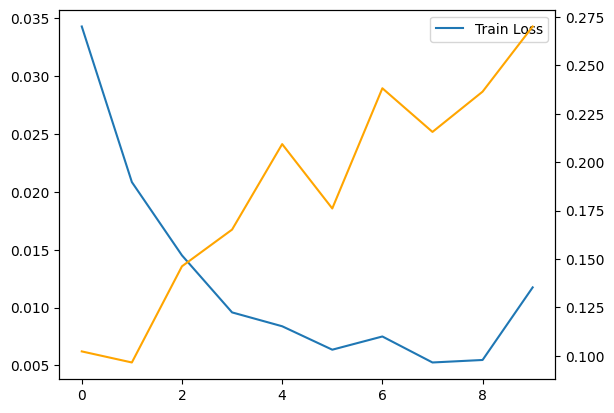

In [9]:
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.gca().twinx().plot(test_losses, label="Test Loss", color="orange")
# torch.save(model.state_dict(), "byol_lr4_ep50.pth")

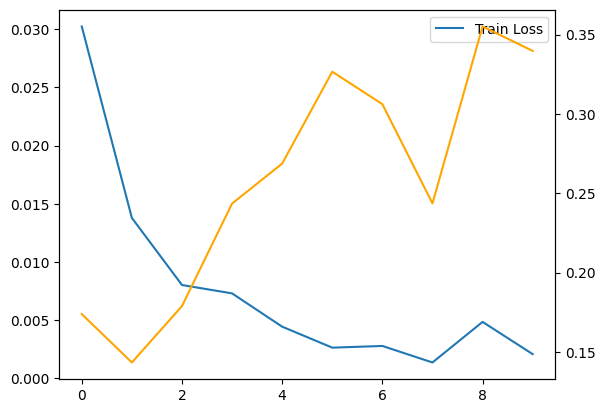